In [1]:
# prep: import modules and get pwd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import pymysql
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


## Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005. 

## Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). This would be our target variable.

## Read the data into a Pandas dataframe.

In [2]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''SELECT * FROM sakila.film f
LEFT JOIN sakila.inventory i USING (film_id)
LEFT JOIN sakila.rental fa USING (inventory_id)
LEFT JOIN sakila.film_category fc USING (film_id)
LEFT JOIN sakila.category c USING (category_id)
LEFT JOIN sakila.payment p USING (rental_id);'''

sakila = pd.read_sql_query(query, engine)
sakila.head()

,rental_id,category_id,film_id,inventory_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,store_id,last_update,rental_date,customer_id,return_date,staff_id,last_update,last_update,name,last_update,payment_id,customer_id,staff_id,amount,payment_date,last_update
0,4863.0,6,1,1.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:09:17,2005-07-08 19:03:15,431.0,2005-07-11 21:29:15,2.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,11630.0,431.0,1.0,0.99,2005-07-08 19:03:15,2006-02-15 22:18:35
1,11433.0,6,1,1.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:09:17,2005-08-02 20:13:10,518.0,2005-08-11 21:35:10,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,13956.0,518.0,2.0,3.99,2005-08-02 20:13:10,2006-02-15 22:20:51
2,14714.0,6,1,1.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:09:17,2005-08-21 21:27:43,279.0,2005-08-30 22:26:43,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,7578.0,279.0,1.0,3.99,2005-08-21 21:27:43,2006-02-15 22:15:20
3,972.0,6,1,2.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:09:17,2005-05-30 20:21:07,411.0,2005-06-06 00:36:07,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,11124.0,411.0,2.0,1.99,2005-05-30 20:21:07,2006-02-15 22:18:08
4,2117.0,6,1,2.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1.0,2006-02-15 05:09:17,2005-06-17 20:24:00,170.0,2005-06-23 17:45:00,2.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,4607.0,170.0,2.0,0.99,2005-06-17 20:24:00,2006-02-15 22:13:42


In [3]:
sakila.shape

(16088, 32)

In [4]:
# convert rental_date to datetime
sakila['rental_date'] = pd.to_datetime(sakila['rental_date'], errors='coerce')

In [5]:
# set may_target column
sakila['may_target'] = pd.DatetimeIndex(sakila['rental_date']).month

In [6]:
sakila.dtypes

rental_id                      float64
category_id                      int64
film_id                          int64
inventory_id                   float64
title                           object
description                     object
release_year                     int64
language_id                      int64
original_language_id            object
rental_duration                  int64
rental_rate                    float64
length                           int64
replacement_cost               float64
rating                          object
special_features                object
last_update             datetime64[ns]
store_id                       float64
last_update             datetime64[ns]
rental_date             datetime64[ns]
customer_id                    float64
return_date             datetime64[ns]
staff_id                       float64
last_update             datetime64[ns]
last_update             datetime64[ns]
name                            object
last_update             d

In [7]:
# set duration_of_rental column

sakila['duration_of_rental'] = (sakila['return_date'] - sakila['rental_date'])

sakila.head()

sum(sakila['duration_of_rental'].isna())

# Replace the NaNs with the column median 

time_median = sakila['duration_of_rental'].median()
time_median
sakila['duration_of_rental'] = sakila['duration_of_rental'].replace({np.nan: time_median}).dt.days

In [8]:
# may_target is the target.
def boolean(x):
    if x==5:
        return 1
    else:
        return 0

sakila['may_target'] = list(map(boolean, sakila['may_target']))

In [9]:
# Convert store_id to a categorical variable (either store one or store 2) before we scale/encode

def alpha(i):
    if i==1:
        return 'A'
    else:
        return 'B'

sakila['store_id'] = list(map(alpha,sakila['store_id']))

sakila.head(20)

,rental_id,category_id,film_id,inventory_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,store_id,last_update,rental_date,customer_id,return_date,staff_id,last_update,last_update,name,last_update,payment_id,customer_id,staff_id,amount,payment_date,last_update,may_target,duration_of_rental
0,4863.0,6,1,1.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-07-08 19:03:15,431.0,2005-07-11 21:29:15,2.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,11630.0,431.0,1.0,0.99,2005-07-08 19:03:15,2006-02-15 22:18:35,0,3
1,11433.0,6,1,1.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-08-02 20:13:10,518.0,2005-08-11 21:35:10,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,13956.0,518.0,2.0,3.99,2005-08-02 20:13:10,2006-02-15 22:20:51,0,9
2,14714.0,6,1,1.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-08-21 21:27:43,279.0,2005-08-30 22:26:43,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,7578.0,279.0,1.0,3.99,2005-08-21 21:27:43,2006-02-15 22:15:20,0,9
3,972.0,6,1,2.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-05-30 20:21:07,411.0,2005-06-06 00:36:07,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,11124.0,411.0,2.0,1.99,2005-05-30 20:21:07,2006-02-15 22:18:08,1,6
4,2117.0,6,1,2.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-06-17 20:24:00,170.0,2005-06-23 17:45:00,2.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,4607.0,170.0,2.0,0.99,2005-06-17 20:24:00,2006-02-15 22:13:42,0,5
5,4187.0,6,1,2.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-07-07 10:41:31,161.0,2005-07-11 06:25:31,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,4381.0,161.0,2.0,0.99,2005-07-07 10:41:31,2006-02-15 22:13:36,0,3
6,9449.0,6,1,2.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-07-30 22:02:34,581.0,2005-08-06 02:09:34,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,15579.0,581.0,1.0,1.99,2005-07-30 22:02:34,2006-02-15 22:22:40,0,6
7,15453.0,6,1,2.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-08-23 01:01:01,359.0,2005-08-30 20:08:01,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,9707.0,359.0,1.0,1.99,2005-08-23 01:01:01,2006-02-15 22:16:52,0,7
8,10126.0,6,1,3.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-02-15 05:09:17,2005-07-31 21:36:07,39.0,2005-08-03 23:59:07,1.0,2006-02-15 21:30:53,2006-02-15 05:07:09,Documentary,2006-02-15 04:46:27,1088.0,39.0,1.0,0.99,2005-07-31 21:36:07,2006-02-15 22:12:38,0,3
9,15421.0,6,1,3.0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,A,2006-

In [10]:
# may_target has 1000 values. 314 film are not rented in May. 686 are rented in May.
sakila1 = sakila.groupby(['title']).agg({'may_target': sum})
sakila['title'].value_counts()
sakila1.value_counts()

may_target
1             355
0             314
2             225
3              76
4              27
5               3
dtype: int64

In [11]:
355+225+76+27+3 # may_target has 1000 values. 314 film are not rented in May. 686 are rented in May.

686

In [12]:
sakila1

,may_target
title,
ACADEMY DINOSAUR,2
ACE GOLDFINGER,0
ADAPTATION HOLES,1
AFFAIR PREJUDICE,2
AFRICAN EGG,1
...,...
YOUNG LANGUAGE,0
YOUTH KICK,0
ZHIVAGO CORE,1


In [13]:
print(sakila.columns.tolist())

['rental_id', 'category_id', 'film_id', 'inventory_id', 'title', 'description', 'release_year', 'language_id', 'original_language_id', 'rental_duration', 'rental_rate', 'length', 'replacement_cost', 'rating', 'special_features', 'last_update', 'store_id', 'last_update', 'rental_date', 'customer_id', 'return_date', 'staff_id', 'last_update', 'last_update', 'name', 'last_update', 'payment_id', 'customer_id', 'staff_id', 'amount', 'payment_date', 'last_update', 'may_target', 'duration_of_rental']


In [14]:
round(sakila.isna().sum()/len(sakila),4)*100

rental_id                 0.27
category_id               0.00
film_id                   0.00
inventory_id              0.26
title                     0.00
description               0.00
release_year              0.00
language_id               0.00
original_language_id    100.00
rental_duration           0.00
rental_rate               0.00
length                    0.00
replacement_cost          0.00
rating                    0.00
special_features          0.00
last_update               0.00
store_id                  0.00
last_update               0.26
rental_date               0.27
customer_id               0.27
return_date               1.41
staff_id                  0.27
last_update               0.27
last_update               0.00
name                      0.00
last_update               0.00
payment_id                0.27
customer_id               0.27
staff_id                  0.27
amount                    0.27
payment_date              0.27
last_update               0.27
may_targ

In [15]:
#Drop columns
columns_raw=list(sakila.columns)

sakila.dropna(axis=1, thresh= 0.80*len(sakila), inplace=True) 
#thresh = x * len(DataFrame) => x: ratio of clean data to all data in rows of the dataframe. 
#The remaining is NaN value. 

columns_result=list(sakila.columns)

columns_dropped=list(set(columns_raw) - set(columns_result))

print(columns_dropped)

['original_language_id']


In [16]:
#Drop columns
def columns_nan(data, list):
    
    for a in list:
        data.drop(a, axis=1, inplace=True) #drop columns
    
#     data.dropna(inplace=True) #drop NaN values
    
    return data

In [17]:
#Drop columns
cols_drop = ['rental_duration','category_id', 'rental_id', 'inventory_id', 'description', 'release_year', 'language_id',
                     'last_update', 'rental_date', 'customer_id', 'return_date', 'staff_id', 'replacement_cost', 'payment_id', 'payment_date', 'special_features', 'title']     

In [18]:
#Drop columns
sakila = columns_nan(sakila,cols_drop)

In [19]:
sakila.shape

(16088, 9)

In [20]:
sakila.head()

,film_id,rental_rate,length,rating,store_id,name,amount,may_target,duration_of_rental
0,1,0.99,86,PG,A,Documentary,0.99,0,3
1,1,0.99,86,PG,A,Documentary,3.99,0,9
2,1,0.99,86,PG,A,Documentary,3.99,0,9
3,1,0.99,86,PG,A,Documentary,1.99,1,6
4,1,0.99,86,PG,A,Documentary,0.99,0,5


In [21]:
sakila.isna().sum() # NaN values each column

film_id                0
rental_rate            0
length                 0
rating                 0
store_id               0
name                   0
amount                44
may_target             0
duration_of_rental     0
dtype: int64

In [22]:
sakila['amount'].value_counts(dropna=False)

4.99     3789
2.99     3542
0.99     2977
5.99     1299
6.99     1119
3.99     1108
7.99      670
1.99      638
8.99      485
9.99      256
10.99     104
NaN        44
0.00       24
11.99      10
3.98        8
5.98        7
7.98        5
9.98        1
1.98        1
8.97        1
Name: amount, dtype: int64

In [23]:
sakila['amount'] = sakila['amount'].fillna('4.99') # the most frequent value

In [24]:
sakila['amount'].value_counts(dropna=False)

4.99     3789
2.99     3542
0.99     2977
5.99     1299
6.99     1119
3.99     1108
7.99      670
1.99      638
8.99      485
9.99      256
10.99     104
4.99       44
0.0        24
11.99      10
3.98        8
5.98        7
7.98        5
9.98        1
1.98        1
8.97        1
Name: amount, dtype: int64

In [25]:
sakila['amount']=pd.to_numeric(sakila['amount'])

In [26]:
sakila['amount'].value_counts(dropna=False)

4.99     3833
2.99     3542
0.99     2977
5.99     1299
6.99     1119
3.99     1108
7.99      670
1.99      638
8.99      485
9.99      256
10.99     104
0.00       24
11.99      10
3.98        8
5.98        7
7.98        5
9.98        1
1.98        1
8.97        1
Name: amount, dtype: int64

In [27]:
sakila.dtypes

film_id                 int64
rental_rate           float64
length                  int64
rating                 object
store_id               object
name                   object
amount                float64
may_target              int64
duration_of_rental      int64
dtype: object

In [28]:
sakila.shape

(16088, 9)

In [29]:
sakila.head(60)

,film_id,rental_rate,length,rating,store_id,name,amount,may_target,duration_of_rental
0,1,0.99,86,PG,A,Documentary,0.99,0,3
1,1,0.99,86,PG,A,Documentary,3.99,0,9
2,1,0.99,86,PG,A,Documentary,3.99,0,9
3,1,0.99,86,PG,A,Documentary,1.99,1,6
4,1,0.99,86,PG,A,Documentary,0.99,0,5
5,1,0.99,86,PG,A,Documentary,0.99,0,3
6,1,0.99,86,PG,A,Documentary,1.99,0,6
7,1,0.99,86,PG,A,Documentary,1.99,0,7
8,1,0.99,86,PG,A,Documentary,0.99,0,3
9,1,0.99,86,PG,A,Documentary,0.99,0,2


In [30]:
sakila.columns

Index(['film_id', 'rental_rate', 'length', 'rating', 'store_id', 'name',
       'amount', 'may_target', 'duration_of_rental'],
      dtype='object')

In [31]:
sakila.shape

(16088, 9)

## Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

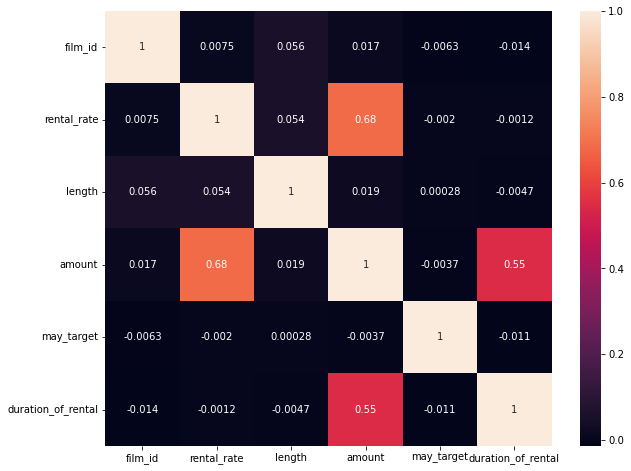

In [32]:
# look for multicolinearity (some columns having almost identical correlation to other variables)
corr_matrix=sakila.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

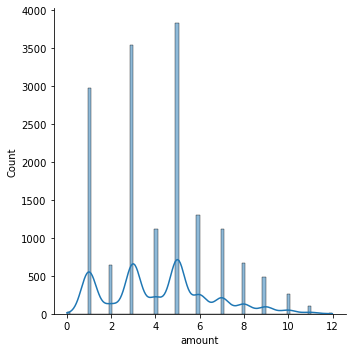

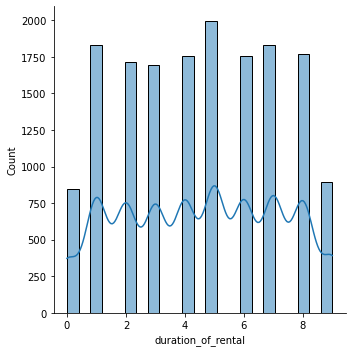

In [33]:
sns.displot(sakila['amount'], kde=True) # distribution plot of amount (payment)
plt.show()

sns.displot(sakila['duration_of_rental'], kde=True) # distribution plot of amount (duration_of_rental)
plt.show()

In [34]:
# Need to X-y-split AND train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = sakila['may_target']
X = sakila.drop('may_target', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [35]:
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = np.object)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num)
x_normalized = transformer.transform(X_train_num)
x_norm = pd.DataFrame(x_normalized, columns=X_train_num.columns)
x_norm.head()

/var/folders/tr/nqbjf62d721fqy35q732j79m0000gn/T/ipykernel_1829/780748270.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_cat = X_train.select_dtypes(include = np.object)


,film_id,rental_rate,length,amount,duration_of_rental
0,0.235235,0.5,0.388489,0.249374,0.444444
1,0.281281,0.0,0.330935,0.165972,0.555556
2,0.742743,0.0,0.100719,0.082569,0.000000
3,0.313313,0.0,0.323741,0.082569,0.000000
4,0.004004,0.5,0.604317,0.332777,0.777778


In [36]:
X_train_num.shape

(12870, 5)

In [37]:
X_train_num.head()

,film_id,rental_rate,length,amount,duration_of_rental
3708,236,2.99,100,2.99,4
4445,282,0.99,92,1.99,5
11900,743,0.99,60,0.99,0
5057,314,0.99,91,0.99,0
71,5,2.99,130,3.99,7


In [38]:
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_train_norm

,film_id,rental_rate,length,amount,duration_of_rental
0,0.235235,0.5,0.388489,0.249374,0.444444
1,0.281281,0.0,0.330935,0.165972,0.555556
2,0.742743,0.0,0.100719,0.082569,0.000000
3,0.313313,0.0,0.323741,0.082569,0.000000
4,0.004004,0.5,0.604317,0.332777,0.777778
...,...,...,...,...,...
12865,0.204204,0.0,0.086331,0.082569,0.111111
12866,0.589590,0.5,0.640288,0.416180,0.555556
12867,0.054054,0.5,0.136691,0.249374,0.111111
12868,0.520521,1.0,0.726619,0.499583,0.888889


In [39]:
sakila.dtypes

film_id                 int64
rental_rate           float64
length                  int64
rating                 object
store_id               object
name                   object
amount                float64
may_target              int64
duration_of_rental      int64
dtype: object

In [40]:
X_train_categorical = X_train.select_dtypes(include = np.object)

X_train_categorical

/var/folders/tr/nqbjf62d721fqy35q732j79m0000gn/T/ipykernel_1829/3510088775.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_categorical = X_train.select_dtypes(include = np.object)


,rating,store_id,name
3708,R,B,Games
4445,NC-17,A,Drama
11900,PG,B,Animation
5057,R,B,Animation
71,G,B,Family
...,...,...,...
3239,NC-17,A,Action
9448,PG,A,New
860,G,A,Sci-Fi
8381,NC-17,B,Drama


In [41]:
# X_train_cat = pd.get_dummies(X_train_categorical, 
#                              columns=['rating','name','store_id'],
#                              drop_first=True)
# X_train_cat.head()

In [42]:
#Encoding categoricals
encoder = OneHotEncoder(drop='first').fit(X_train_categorical)
cols = encoder.get_feature_names(input_features=X_train_categorical.columns)

/Users/ozguryildirim/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
print(encoder.categories_)

[array(['G', 'NC-17', 'PG', 'PG-13', 'R'], dtype=object), array(['A', 'B'], dtype=object), array(['Action', 'Animation', 'Children', 'Classics', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Foreign', 'Games', 'Horror',
       'Music', 'New', 'Sci-Fi', 'Sports', 'Travel'], dtype=object)]


In [44]:
encoded = encoder.transform(X_train_categorical).toarray()
print(encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [45]:
onehot_encoded = pd.DataFrame(encoded,columns=cols)
onehot_encoded.head(5)

,rating_NC-17,rating_PG,rating_PG-13,rating_R,store_id_B,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = np.concatenate([X_train_norm, onehot_encoded], axis=1)

In [47]:
#array
X_train_transformed

array([[0.23523524, 0.5       , 0.38848921, ..., 0.        , 0.        ,
        0.        ],
       [0.28128128, 0.        , 0.33093525, ..., 0.        , 0.        ,
        0.        ],
       [0.74274274, 0.        , 0.10071942, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.05405405, 0.5       , 0.13669065, ..., 1.        , 0.        ,
        0.        ],
       [0.52052052, 1.        , 0.72661871, ..., 0.        , 0.        ,
        0.        ],
       [0.2032032 , 0.        , 0.43165468, ..., 0.        , 0.        ,
        0.        ]])

In [48]:
print(X_train_transformed.shape,y_train.shape)

(12870, 25) (12870,)


## Create a logistic regression model to predict this variable from the cleaned data.

In [ ]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

#classifications allow me to predict.

In [ ]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm.shape

In [ ]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating','name','store_id'],
                            drop_first=True)
# verify that dummies columns are in the same order and that the same column was dropped
display(list(zip(list(X_train_categorical.columns),list(X_test_cat.columns))))
# not needed if you treat each dataframe with one_hot_encoder and save the encode (and the column names)

X_test_cat.head()

In [ ]:
X.shape

In [ ]:
X_test_norm.shape

In [ ]:
X_test_cat.shape

In [ ]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [ ]:
predictions = classification.predict(X_test_transformed)
predictions
classification.score(X_test_transformed, y_test)

In [ ]:
print(y_test.value_counts())
# As you would notice here, there is a huge imbalance in the data among the different classes. 
# We will talk more about imbalance and how to resolve it later (tomorrow)

In [ ]:
pd.Series(predictions).value_counts()
# This shows that the disparity in the numbers are amplified by the model

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

# number of times of predictions

In [ ]:
# KNN classifier: look at nearest neighbours and use the majority to determine class
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

In [ ]:
confusion_matrix(y_test, predictions_clf)

In [ ]:
pd.Series(y_test).value_counts()

In [ ]:
pd.Series(predictions_clf).value_counts()

## Evaluate the results. 

In [ ]:
# The target feature is may_target. The logistic regression model is applied to predict which
# films to be rented in May. The predictions indicate a score of 0.93. 
# KNN classifier also results in 0.93 score. 
# These results imply that the model predicts accurately.

## BONUS

### Now that you have your model, trained and tested, you are able to predict which films will be rented in June.

### Create a query or queries to extract the same information you used to build your prediction model.

### Create a query to get the list of films and a boolean indicating if it was rented last month (June 2005). This would be our target variable.

### Read the data into a Pandas dataframe.

In [ ]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''SELECT * FROM sakila.film f
LEFT JOIN sakila.inventory i USING (film_id)
LEFT JOIN sakila.rental fa USING (inventory_id)
LEFT JOIN sakila.film_category fc USING (film_id)
LEFT JOIN sakila.category c USING (category_id)
LEFT JOIN sakila.payment p USING (rental_id);'''

sakila_june = pd.read_sql_query(query, engine)
sakila_june.head()

In [ ]:
# convert rental_date to datetime
sakila_june['rental_date'] = pd.to_datetime(sakila_june['rental_date'], errors='coerce')

In [ ]:
# set may_target column
sakila_june['june_target'] = pd.DatetimeIndex(sakila_june['rental_date']).month

In [ ]:
# set duration_of_rental column

sakila_june['duration_of_rental'] = (sakila_june['return_date'] - sakila_june['rental_date'])

sakila_june.head()

sum(sakila_june['duration_of_rental'].isna())

# Replace the NaNs with the column median 

time_median = sakila_june['duration_of_rental'].median()
time_median
sakila_june['duration_of_rental'] = sakila_june['duration_of_rental'].replace({np.nan: time_median}).dt.days

In [ ]:
# june_target is the target.
def boolean(x):
    if x==6:
        return 1
    else:
        return 0

sakila_june['june_target'] = list(map(boolean, sakila_june['june_target']))

In [ ]:
# Convert store_id to a categorical variable (either store one or store 2) before we scale/encode

def alpha(i):
    if i==1:
        return 'A'
    else:
        return 'B'

sakila_june['store_id'] = list(map(alpha,sakila_june['store_id']))

sakila_june.head(20)

In [ ]:
# june_target has 1000 values. 100 film are not rented in June. 900 are rented in June.
sakila2 = sakila_june.groupby(['title']).agg({'june_target': sum})
sakila_june['title'].value_counts()
sakila2.value_counts()

In [ ]:
275+222+206+118+58+20+1 # june_target has 1000 values. 100 film are not rented in June. 900 are rented in June.

In [ ]:
sakila2

In [ ]:
print(sakila_june.columns.tolist())

In [ ]:
round(sakila_june.isna().sum()/len(sakila_june),4)*100

In [ ]:
#Drop columns
columns_raw=list(sakila_june.columns)

sakila_june.dropna(axis=1, thresh= 0.80*len(sakila_june), inplace=True) 
#thresh = x * len(DataFrame) => x: ratio of clean data to all data in rows of the dataframe. 
#The remaining is NaN value. 

columns_result=list(sakila_june.columns)

columns_dropped=list(set(columns_raw) - set(columns_result))

print(columns_dropped)

In [ ]:
#Drop columns
def columns_nan(data, list):
    
    for a in list:
        data.drop(a, axis=1, inplace=True) #drop columns
    
#     data.dropna(inplace=True) #drop NaN values
    
    return data

In [ ]:
#Drop columns
cols_drop = ['rental_duration','category_id', 'rental_id', 'inventory_id', 'description', 'release_year', 'language_id',
                     'last_update', 'rental_date', 'customer_id', 'return_date', 'staff_id', 'replacement_cost', 'payment_id', 'payment_date', 'special_features', 'title']     

In [ ]:
#Drop columns
sakila_june = columns_nan(sakila_june,cols_drop)

In [ ]:
sakila_june.shape

In [ ]:
sakila_june.head()

In [ ]:
sakila_june.isna().sum() # NaN values each column

In [ ]:
sakila_june['amount'].value_counts(dropna=False)

In [ ]:
sakila_june['amount'] = sakila_june['amount'].fillna('4.99') # the most frequent value

In [ ]:
sakila_june['amount'].value_counts(dropna=False)

In [ ]:
sakila_june['amount']=pd.to_numeric(sakila_june['amount'])

In [ ]:
sakila_june['amount'].value_counts(dropna=False)

In [ ]:
sakila_june.dtypes

In [ ]:
sakila_june.shape

In [ ]:
sakila.head(60)

In [ ]:
sakila_june.columns

In [ ]:
sakila_june.shape

### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [ ]:
# look for multicolinearity (some columns having almost identical correlation to other variables)
corr_matrix=sakila_june.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
sns.displot(sakila_june['amount'], kde=True) # distribution plot of amount (payment)
plt.show()

sns.displot(sakila_june['duration_of_rental'], kde=True) # distribution plot of amount (duration_of_rental)
plt.show()

In [ ]:
#X-y split
y2 = sakila_june['june_target']
X2 = sakila_june.drop('june_target', axis=1)

In [ ]:
# from sklearn.preprocessing import StandardScaler

X_num2 = X2.select_dtypes(include = np.number)
X_cat2 = X2.select_dtypes(include = np.object)


In [ ]:
X_num2.shape

In [ ]:
X_num2.head()

In [ ]:
# MINMAX Scaling data

X_normalized2 = transformer.transform(X_num2)
X_norm2 = pd.DataFrame(X_normalized2, columns=X_num2.columns)
X_norm2.head()

In [ ]:
sakila_june.dtypes

In [ ]:
X_cat2

In [ ]:
#Encoding categoricals
encoded2 = encoder.transform(X_cat2).toarray()
cols2 = encoder.get_feature_names(input_features=X_cat2.columns)
onehot_encoded2 = pd.DataFrame(encoded2,columns=cols2)

In [ ]:
print(encoder.categories_)

In [ ]:
print(encoded2)

In [ ]:
onehot_encoded2.head(5)

In [ ]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_transformed2 = np.concatenate([X_norm2, onehot_encoded2], axis=1)

In [ ]:
#array
X_transformed2

## Create a logistic regression model to predict this variable from the cleaned data.

In [ ]:
from sklearn.linear_model import LogisticRegression
classification2 = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_transformed2, y2)

#classifications allow me to predict.

In [ ]:
predictions2 = classification2.predict(X_transformed2)
predictions2
classification2.score(X_transformed2, y2)

In [ ]:
print(y2.value_counts())
# As you would notice here, there is a huge imbalance in the data among the different classes. 
# We will talk more about imbalance and how to resolve it later (tomorrow)

In [ ]:
pd.Series(predictions2).value_counts()
# This shows that the disparity in the numbers are amplified by the model

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y2, predictions2)

# number of times of predictions

# predicted | A | B | C | D |
# --------------------------
# actual  A | + |  |   |   |
# --------------------------
#         B |   | + |   |   |
# --------------------------
#         C |   |   | + |   |
# --------------------------
#         D |   |   |   | + |



In [ ]:
# KNN classifier: look at nearest neighbours and use the majority to determine class
from sklearn import neighbors
predictions_clf2 = clf.predict(X_transformed2)
clf.score(X_transformed2, y2)

In [ ]:
confusion_matrix(y2, predictions_clf2)

In [ ]:
pd.Series(y2).value_counts()

In [ ]:
pd.Series(predictions_clf2).value_counts()

### Make your predictions using your previous model.